# Optional - CellLENS (Full version) with ViT transformer architecture:

# Analysis on Murine-spleen CODEX Data with morphology images

In this tutorial, we will run CellLENS full version but with a more complex architecture for extracting image level information.

The speed would be slower than our default Alex-Net Model. Performance would be slightly better but we have not performed extensive benchmarking and evaluations on this.

This is more for potential development tasks.

## Step 0: Load packages

In [1]:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
import sys
sys.path.append("../src/")
##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys

from celllens.utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from celllens.preprocessing import *
from celllens.datasets import *
from celllens.celllens import *
import seaborn as sns

## packages for loading dataset deposited on Zenodo
import requests
import tifffile as tiff
import io

## for clearity
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

/gpfs/radev/home/bz293/.conda/envs/cell_github/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
## since in this CellLENS version we will use GPU (thus cuda), we can also run it on google colab

## if running on google colab etc
if 'google.colab' in str(get_ipython()):
  RUN_COLAB = True
else:
  RUN_COLAB = False

## Step I: Read in the data

We first load the codex murine dataset

In [3]:
# we have deposited the tutorial data onto zenodo for convinient loading
df_url = 'https://zenodo.org/records/14629754/files/features_and_metadata.csv?download=1'

df = pd.read_csv(df_url, index_col = 0)

Here in the tutorial we provided an example dataset (CODEX murine spleen data, from Goltsev et al, Cell, 2018).

The columns should be self explainable - with protein **feature expression profiles**, and some related meta data, including **cell locations** etc

Since in this tutorial we will use the image morphology information, we will need to load the images too.

### We are skipping all image processing in this notebook - because the same process has been shown in the default version.

## Step II: Initialize the object

In [4]:
## these are the expression profile (proteins)

features_list = [
    'CD45', 'Ly6C', 'TCR', 'Ly6G', 'CD19', 'CD169', 'CD106', 'CD3', 'CD1632', 
    'CD8a', 'CD90', 'F480', 'CD11c', 'Ter119', 'CD11b', 'IgD', 'CD27', 'CD5', 
    'CD79b', 'CD71', 'CD31', 'CD4', 'IgM', 'B220', 'ERTR7', 'MHCII', 'CD35', 
    'CD2135', 'CD44', 'nucl', 'NKp46'
]


Then we can first initialize the object

In [5]:
# optionally, clean data Nans - in case data have fault
df.fillna(0, inplace=True)

murine_dataset = LENS_Dataset(df,
                              features_list=features_list,
                              nbhd_composition=15,
                              feature_neighbor=15,
                              spatial_neighbor=15,
                              path2img='../../../code/processed_images/', # location to store cropped images - already processed
                              use_transform = False) # processed image saving location - in later steps

In [6]:
import warnings
warnings.filterwarnings('ignore')

murine_dataset.initialize(cent_x="centroid_x", # x loc of cells
                          cent_y="centroid_y", # y loc of cells
                          celltype="feature_labels", # default option - run leiden to initialize the clusters
                          pca_components=25, # PCA components to use, user decide 
                          cluster_res=0.5) # leiden initialization resolution

Leiden clustering identified 15 clusters as input population identity.
Calculating cell neighborhood composition matrix...
Constructing the graph...
Done!


### Skipping image cropping and saving - already done if have previously run tutorial 2 (Alex-Net default).

## Step II: Train CellLENS with Morphology

There are two steps for training CellLENS:
    1. Train LENS CNN to get CNN embedding
    2. Train LENS GNN duo to get GNN embedding

### part 1: Train LENS-CNN

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
murine_celllens = CellLENS(murine_dataset,
                           device,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32,
                           cnn_model='ViT',
                           input_channel_num=2 # this case the images have two channels, nuclear and membrane, thus 2
                          ) # generally these parameters no need to change

In [8]:
murine_celllens.fit_lens_cnn(
                     batch_size=64,
                     learning_rate=1e-4,
                     n_epochs=5, #### NOTE: setting to 5 for saving time on this tutorial. NOTE: ViT only need 50-100 epochs to converge.
                     loss_fn='MSELoss',
                     OptimizerAlg='Adam',
                     optimizer_kwargs={},
                     SchedulerAlg=None,
                     scheduler_kwargs={},
                     print_every=1000, # could print more if want to monitor loss more
                     cnn_model='ViT') # generally other parameters dont need to be changed - unless for specfic reason


=============Training convolutional neural network============

Epoch 1/5


Epoch 1: 100%|██████████| 836/836 [06:52<00:00,  2.03batch/s, loss=0.005643]


Epoch 2/5


Epoch 2: 100%|██████████| 836/836 [06:47<00:00,  2.05batch/s, loss=0.002971]


Epoch 3/5


Epoch 3: 100%|██████████| 836/836 [06:47<00:00,  2.05batch/s, loss=0.001973]


Epoch 4/5


Epoch 4: 100%|██████████| 836/836 [06:50<00:00,  2.04batch/s, loss=0.001380]


Epoch 5/5


Epoch 5: 100%|██████████| 836/836 [06:49<00:00,  2.04batch/s, loss=0.001012]


This tutorial was ran on one NVIDIA A40 GPU, and on a SSD disk. The estimated per-epoch time is ~5 mins. Thus the total run time with 50 epochs would be around 4 hrs for retraining the CNN model (with the ViT architecture). This process would thus **require longer run time** compared to default.

In [9]:
murine_celllens.get_cnn_embedding(batch_size=512, # generally these parameters no need to change
                                  path2result='../CellLENS_saveouts_ViT')


=====Save CNN Embedding!============



If training is already done seperately, we can also directly load the saved out embedding

### Train LENS GNN

In [10]:
murine_celllens.get_lens_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True) # generally these parameters do not need to change

===Epoch 500, the training loss is 0.00440107==
===Epoch 1000, the training loss is 0.00328736==
===Epoch 1500, the training loss is 0.00285322==
===Epoch 2000, the training loss is 0.00262085==
===Epoch 2500, the training loss is 0.00242881==
===Epoch 3000, the training loss is 0.00228951==
===Epoch 3500, the training loss is 0.00219298==
===Epoch 4000, the training loss is 0.00211239==
===Epoch 4500, the training loss is 0.00203375==
===Epoch 5000, the training loss is 0.00198074==

=========Get Current Round CellLENS Embedding!============

===Epoch 500, the training loss is 0.00454501==
===Epoch 1000, the training loss is 0.00324650==
===Epoch 1500, the training loss is 0.00284415==
===Epoch 2000, the training loss is 0.00260020==
===Epoch 2500, the training loss is 0.00242600==
===Epoch 3000, the training loss is 0.00228270==
===Epoch 3500, the training loss is 0.00217651==
===Epoch 4000, the training loss is 0.00209422==
===Epoch 4500, the training loss is 0.00202787==
===Epoch 5

The GNN training part should be relatively fast. We train a total of 5 repeated times. The total time should be ~ 10 mins for this dataset.

The memory usage here is dependent on cell numbers, which the GPU need to store the cell graph. The memory usage on 50k cells is ~ 7GB.

## Step III: LENS Clustering & Visualization

In [11]:
# the resulting CellLENS embedding is stored here:
pd.DataFrame(murine_celllens.lens_embedding)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,8.455473,-1.990921,2.432709,-0.966773,0.943305,0.721725,0.166320,1.198673,1.793649,-0.189919,...,0.265086,-0.202937,-0.846205,-0.378690,-0.384116,-0.711194,-0.056345,-0.430254,0.270557,0.194199
1,5.075377,-0.758810,-0.621799,0.686724,0.544857,-0.865685,3.115545,0.190095,-1.510452,0.491278,...,1.238198,0.613632,-0.250302,-0.431392,-0.216797,-0.357125,-0.165696,0.107056,-0.152647,-0.208819
2,6.568249,-1.652618,0.519039,0.194000,0.454211,-0.411958,2.476349,1.155340,-0.149506,0.214163,...,0.398555,0.113177,-0.588351,-0.318164,-1.354411,-0.290177,0.222301,-0.178651,0.014123,0.586296
3,7.011482,-1.086078,2.909563,3.224096,-0.799669,0.422292,0.572840,0.799329,-0.647271,0.297734,...,-0.194931,0.178792,-0.576100,0.609661,0.349575,-0.455516,-0.682907,0.241760,-0.190710,0.231816
4,5.828180,-0.477484,-0.749720,0.145875,0.451061,-0.219234,3.941766,0.842693,-1.898914,1.249693,...,0.004617,-0.291655,0.152250,0.439065,-0.009773,-0.420612,-0.366293,0.279813,-0.638564,0.578022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,4.698307,-0.757101,0.417661,-0.296382,0.791007,-0.487350,4.182342,-0.073759,-2.239105,0.168150,...,-0.265043,-0.130327,0.481219,-0.194875,-0.141802,-0.151562,-0.422667,0.092375,-0.272245,-0.016956
53496,10.831154,-0.581253,6.576249,-2.371328,1.386941,0.713992,1.338663,-5.399293,-4.931750,-3.241379,...,0.699931,-0.160758,0.319805,-0.773819,-0.571224,0.175301,-0.344991,-0.157664,-0.811049,-0.408645
53497,8.888705,-0.023973,4.970707,-1.637186,1.710104,0.496776,1.665362,-3.927530,-3.045176,-1.816633,...,0.538360,-0.217357,0.599942,-0.302886,-0.364192,0.320625,-0.440261,-0.259461,-1.091097,-0.696363
53498,7.717550,0.185478,4.588911,-1.037415,1.778350,0.714296,1.865802,-3.541370,-1.947375,-1.248411,...,-0.313535,0.227604,0.535138,-0.076516,-0.357848,0.332575,-0.283422,-0.679311,-0.715081,-0.183628


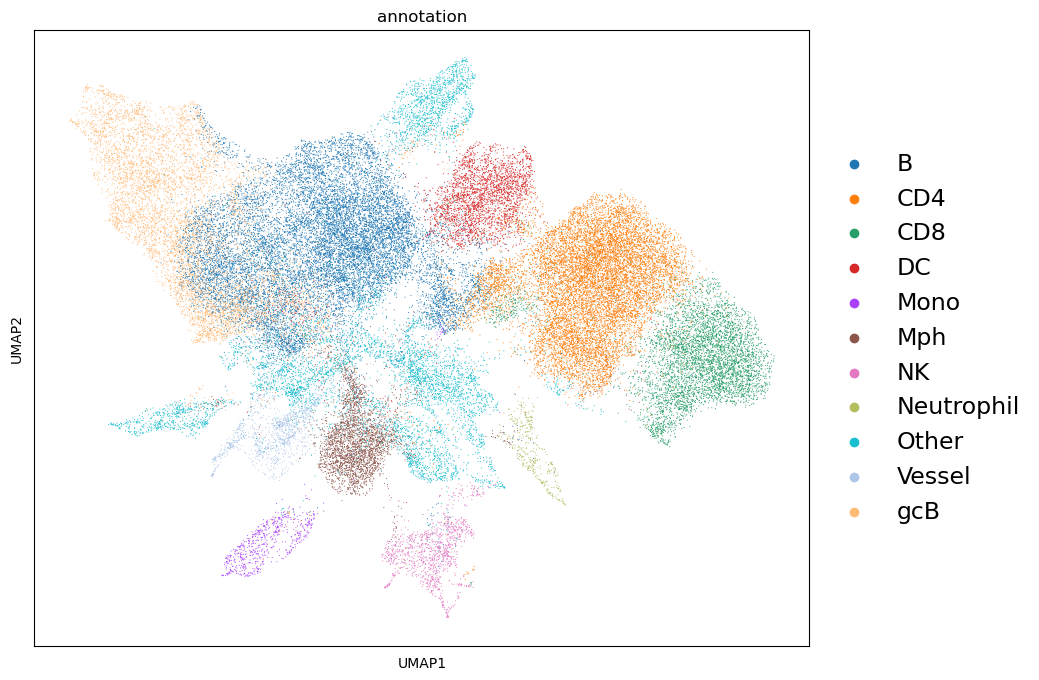

In [12]:
# we also have a wrapper function for quick UMAP visualization of the CellLENS embedding
murine_celllens.visualize_umap(murine_celllens.lens_embedding, murine_dataset.df['cluster.termV2']) # here coloring with original cell lables

With the CellLENS embedding available, we can perform clustering and identify different cell populations.

We provide a function for Leiden clustering in our package for convinient usage.



In [13]:
murine_celllens.get_lens_clustering(neighbor=15, # standard leiden parameter
                                    resolution=1.0, # resolution for leiden - specific
                                    entropy_threshold=0.75, # CellLENS parameter - generally no change needed
                                    concen_threshold=1, # CellLENS parameter - generally no change needed
                                    max_breaks=3, # CellLENS parameter - generally no change needed
                                    size_lim=50 # CellLENS parameter - smallest cluster size allowed
                                   )

And then we can visualize the results on the UMAP.

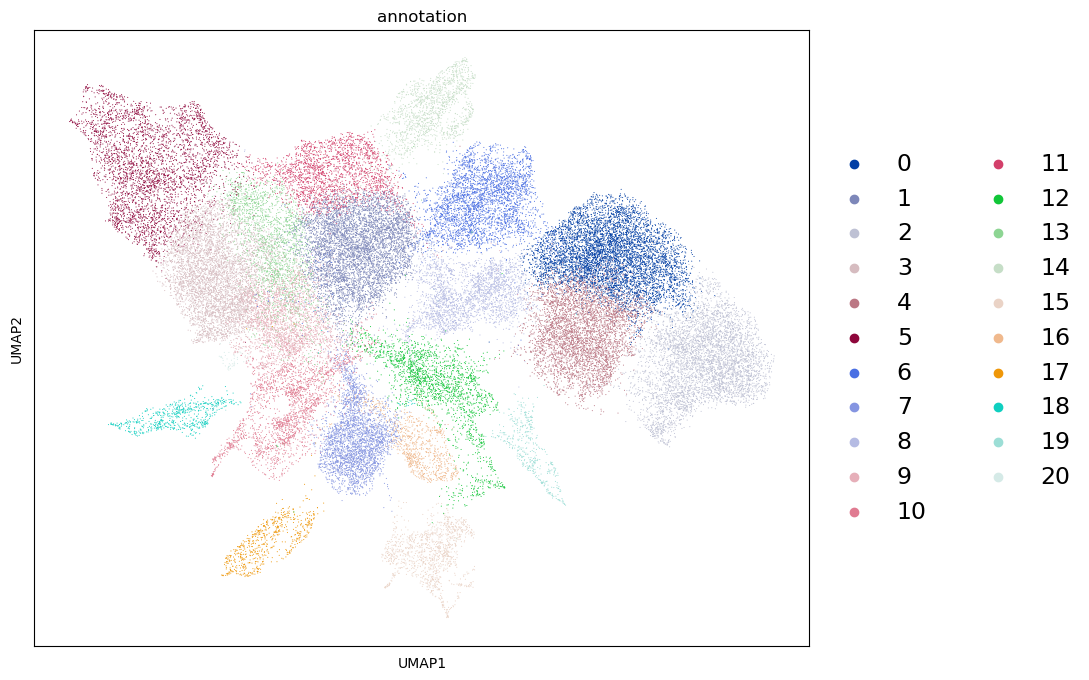

In [14]:
murine_celllens.visualize_umap(murine_celllens.lens_embedding, murine_celllens.lens_clustering)

In [15]:
# the clustering results can also be easily accessed here
murine_celllens.lens_clustering

['10',
 '7',
 '10',
 '1',
 '7',
 '7',
 '7',
 '12',
 '1',
 '4',
 '19',
 '7',
 '1',
 '1',
 '7',
 '16',
 '9',
 '6',
 '7',
 '2',
 '10',
 '9',
 '17',
 '7',
 '2',
 '2',
 '9',
 '6',
 '4',
 '6',
 '7',
 '2',
 '10',
 '15',
 '10',
 '2',
 '2',
 '18',
 '7',
 '10',
 '8',
 '7',
 '1',
 '19',
 '1',
 '1',
 '1',
 '7',
 '10',
 '7',
 '18',
 '7',
 '7',
 '7',
 '1',
 '15',
 '1',
 '7',
 '7',
 '9',
 '7',
 '6',
 '7',
 '4',
 '1',
 '9',
 '12',
 '7',
 '8',
 '7',
 '19',
 '7',
 '1',
 '1',
 '1',
 '12',
 '1',
 '12',
 '10',
 '8',
 '18',
 '16',
 '1',
 '7',
 '2',
 '10',
 '12',
 '4',
 '18',
 '4',
 '7',
 '12',
 '7',
 '12',
 '7',
 '9',
 '7',
 '18',
 '1',
 '2',
 '1',
 '7',
 '6',
 '6',
 '7',
 '19',
 '19',
 '10',
 '7',
 '2',
 '12',
 '1',
 '7',
 '9',
 '10',
 '1',
 '9',
 '1',
 '6',
 '7',
 '6',
 '4',
 '6',
 '1',
 '6',
 '1',
 '1',
 '4',
 '10',
 '10',
 '6',
 '10',
 '2',
 '12',
 '7',
 '6',
 '10',
 '10',
 '9',
 '8',
 '12',
 '17',
 '2',
 '8',
 '4',
 '10',
 '7',
 '7',
 '10',
 '1',
 '2',
 '8',
 '10',
 '4',
 '8',
 '10',
 '12',
 '1',
 '9',

One could easily save this result out and perform your various downstream analysis.